In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# In R, this can be computed using scales::pal_hue()(4)
hex_palette = ['#F8766D', '#7CAE00', '#00BFC4', '#C77CFF']
rgb_palette = [(248, 118, 109), (124, 174, 0), (0, 191, 196), (199, 124, 255)]

In [2]:
operator_map = {
    "phecode": "Phecode",
    "and": "and(x, y)",
    "not": "and(x, not(y))",
    "or": "or(x, y)",
}
operator_order = list(operator_map.values())
print(operator_order)

['Phecode', 'and(x, y)', 'and(x, not(y))', 'or(x, y)']


<Figure size 800x800 with 0 Axes>

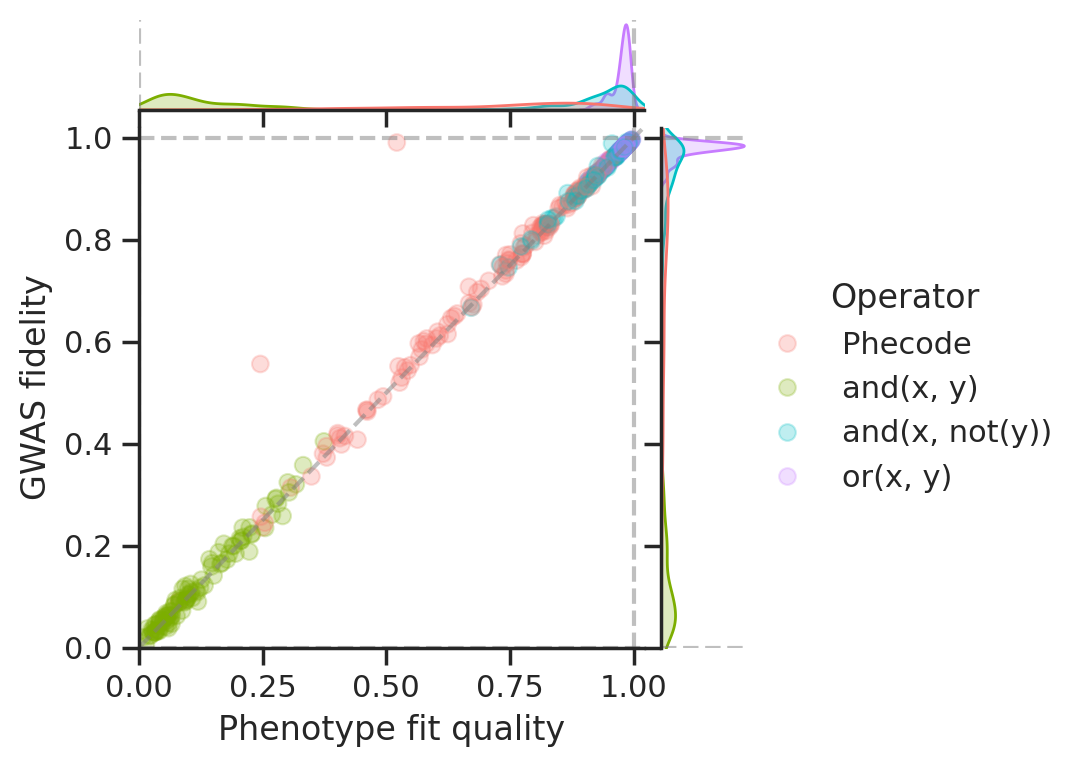

In [3]:
anon_df = (
    pl.scan_parquet("data/pheno_summary/direct_vs_indirect_anon.parquet")
    .join(pl.scan_parquet("data/gwas_summary/direct_vs_indirect_anon.parquet"), on=["kind", "phenotype", "k"], suffix="_gwas")
    .rename({"rsq": "rsq_pheno"})
    .with_columns(
        (
            pl.col("phenotype")
            .str.extract("^(and|or|not)")
            .fill_null("phecode")
            .replace({
                "phecode": "Phecode",
                "and": "and(x, y)",
                "not": "and(x, not(y))",
                "or": "or(x, y)",
            })
            .alias("operator")
        ),
        pl.col("k").cast(pl.Int32).cast(pl.String),
    )
    .collect()
)

sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(hex_palette)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(4, 4))

(
    anon_df
    .filter(pl.col("k").eq("10"))
    .pipe(
        sns.jointplot, x="rsq_pheno", y="r_gwas", hue="operator", alpha=0.25, 
        xlim=(0.0, 1.02), ylim=(0.0, 1.02), 
        hue_order=operator_order, 
        height=4, edgecolors="face", linewidths=0.75, marginal_kws={'common_norm': False, "bw_adjust": 0.9}
    )
    .refline(x=0, y=0, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=1, y=1, linestyle="dashed", color="gray", alpha=0.5)
)
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
lgd = plt.legend(
    bbox_to_anchor=(1.17, 0.5), loc="center left", title="Operator", frameon=False
)
plt.savefig(
    "img/overall-performance-marginal.png", dpi=400, 
    format="png", bbox_extra_artists=(lgd,), bbox_inches='tight'
)

<Figure size 800x800 with 0 Axes>

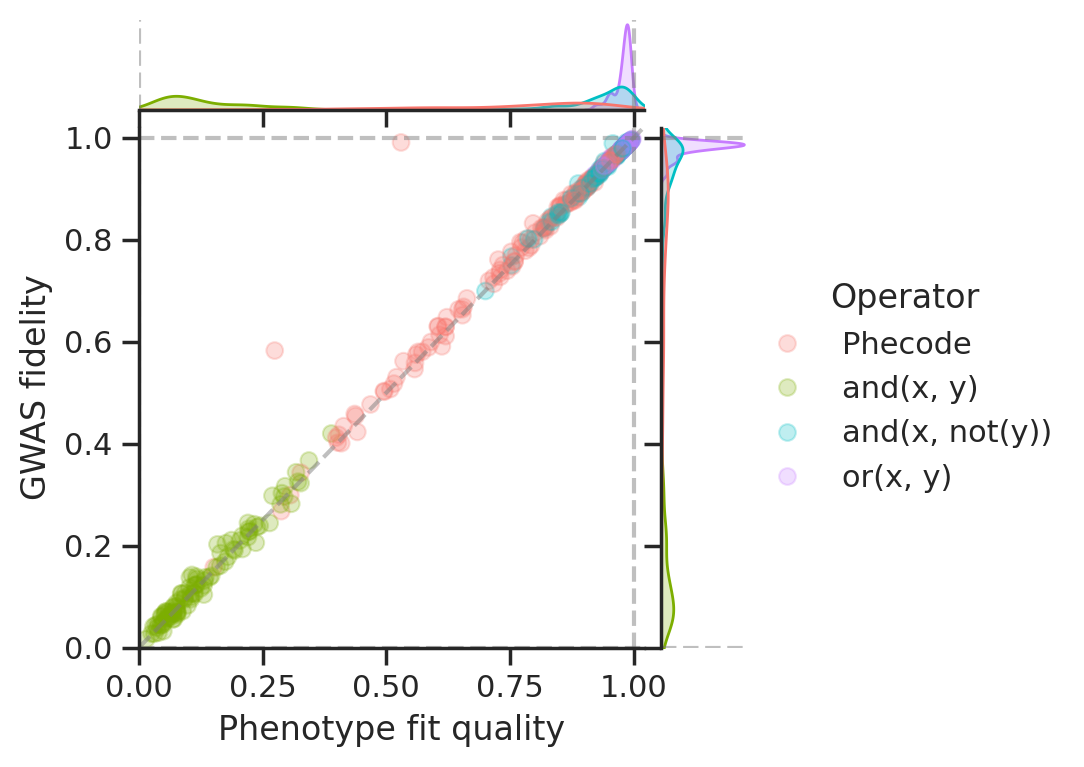

In [4]:
non_anon_df = (
    pl.scan_parquet("data/pheno_summary/direct_vs_indirect_non_anon.parquet")
    .join(pl.scan_parquet("data/gwas_summary/direct_vs_indirect_non_anon.parquet"), on=["kind", "phenotype"], suffix="_gwas")
    .rename({"rsq": "rsq_pheno"})
    .with_columns(
        pl.col("phenotype")
        .str.extract("^(and|or|not)")
        .fill_null("phecode")
        .replace({
            "phecode": "Phecode",
            "and": "and(x, y)",
            "not": "and(x, not(y))",
            "or": "or(x, y)",
        })
        .alias("operator")
    )
    .collect()
)

sns.set_style("ticks")
sns.set_context("notebook")
sns.set_palette(hex_palette)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(4, 4))

(
    non_anon_df
    .pipe(
        sns.jointplot, x="rsq_pheno", y="r_gwas", hue="operator", alpha=0.25, 
        xlim=(0.0, 1.02), ylim=(0.0, 1.02), 
        hue_order=operator_order, 
        height=4, edgecolors="face", linewidths=0.75, marginal_kws={'common_norm': False, "bw_adjust": 0.9}
    )
    .refline(x=0, y=0, linestyle="dashed", color="gray", alpha=0.5)
    .refline(x=1, y=1, linestyle="dashed", color="gray", alpha=0.5)
)
plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
plt.xlabel("Phenotype fit quality")
plt.ylabel("GWAS fidelity")
lgd = plt.legend(
    bbox_to_anchor=(1.17, 0.5), loc="center left", title="Operator", frameon=False
)
plt.savefig(
    "img/linearization-performance-marginal.png", dpi=400, 
    format="png", bbox_extra_artists=(lgd,), bbox_inches='tight'
)

In [5]:
(
    non_anon_df
    .group_by(["kind", "operator"])
    .agg(
        median=pl.col("rsq_pheno").median(),
        mean=pl.col("rsq_pheno").mean(),
        std=pl.col("rsq_pheno").std(),
        min=pl.col("rsq_pheno").min(),
        max=pl.col("rsq_pheno").max(),
    )
)

kind,operator,median,mean,std,min,max
str,str,f64,f64,f64,f64,f64
"""boolean""","""and(x, y)""",0.105252,0.13321,0.08786,0.014487,0.388655
"""boolean""","""or(x, y)""",0.98351,0.976848,0.017502,0.91885,0.997721
"""phecodes""","""Phecode""",0.821396,0.759419,0.184165,0.151203,0.981746
"""boolean""","""and(x, not(y))""",0.960643,0.935789,0.06088,0.700258,0.995484


In [6]:
(
    non_anon_df
    .select(
        mean=pl.col("rsq_pheno").ge(0.5).mean(),
        sum=pl.col("rsq_pheno").ge(0.5).sum(),
        n=pl.len()
    )
)

mean,sum,n
f64,u32,u32
0.736364,324,440


In [7]:
(
    non_anon_df
    .select(
        mean=pl.col("rsq_pheno").ge(0.75).mean(),
        sum=pl.col("rsq_pheno").ge(0.75).sum(),
        n=pl.len()
    )
)

mean,sum,n
f64,u32,u32
0.656818,289,440


In [8]:
(
    non_anon_df
    .select(
        pl.col("rsq_gwas", "rsq_pheno").mean(),
        r = pl.corr("rsq_gwas", "rsq_pheno")
    )
)

rsq_gwas,rsq_pheno,r
f64,f64,f64
0.623232,0.706599,0.982902


In [9]:
(
    anon_df
    .select(
        pl.col("rsq_gwas", "rsq_pheno").mean(),
        r = pl.corr("rsq_gwas", "rsq_pheno"),
    )
)

rsq_gwas,rsq_pheno,r
f64,f64,f64
0.59757,0.684681,0.981002


In [10]:
(
    anon_df
    .filter(pl.col("k").eq("10"))
    .select(
        mean=pl.col("rsq_gwas").ge(0.5).mean(),
        sum=pl.col("rsq_gwas").ge(0.5).sum(),
        n=pl.len()
    )
    .with_columns(
        label=pl.col("mean").round(2).mul(100).cast(pl.Int32).cast(pl.String) + pl.lit(r"\% (") + pl.col("sum").cast(pl.String) + pl.lit("/") + pl.col("n").cast(pl.String) + pl.lit(")")
    )
)

mean,sum,n,label
f64,u32,u32,str
0.663636,292,440,"""66\% (292/440)"""


In [11]:
(
    anon_df
    .filter(pl.col("k").eq("10"))
    .select(
        mean=pl.col("rsq_pheno").ge(0.75).mean(),
        sum=pl.col("rsq_pheno").ge(0.75).sum(),
        n=pl.len()
    )
    .with_columns(
        label=pl.col("mean").round(2).mul(100).cast(pl.Int32).cast(pl.String) + pl.lit(r"\% (") + pl.col("sum").cast(pl.String) + pl.lit("/") + pl.col("n").cast(pl.String) + pl.lit(")")
    )
)

mean,sum,n,label
f64,u32,u32,str
0.631818,278,440,"""63\% (278/440)"""
